In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
data = pd.read_csv('data/processed/tep_data.csv', index_col='Index')
print(f'Len of dataset: {data.shape[0]}')


Len of dataset: 12801


In [3]:
import importlib
import src.models.DDRE
importlib.reload(src.models.DDRE)


<module 'src.models.DDRE' from 'd:\\anomaly-detection\\src\\models\\DDRE.py'>

In [4]:
from src.models.DDRE import DensityRatioEstimation, get_sequences_of_samples
sigma = 10
n_rf=16
n_te=16
k=8

Y_re = get_sequences_of_samples(data, 0, n_rf, k)
Y_te = get_sequences_of_samples(data, n_rf, n_te, k)

dre = DensityRatioEstimation(sigma)

dre.build(Y_re, Y_te)


In [5]:
%%time
ratios = dre.compute_ratios(data)


Wall time: 1.8 s


(array([2148., 2582., 2104., 2279., 2092., 1108.,  376.,   76.,   20.,
           8.]),
 array([1.05972598e-04, 1.54949894e-01, 3.09793814e-01, 4.64637735e-01,
        6.19481656e-01, 7.74325577e-01, 9.29169498e-01, 1.08401342e+00,
        1.23885734e+00, 1.39370126e+00, 1.54854518e+00]),
 <a list of 10 Patch objects>)

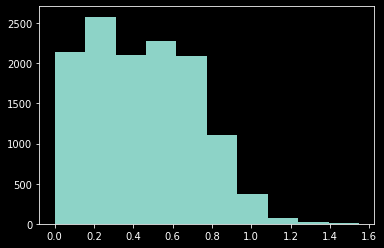

In [6]:
plt.hist(ratios)
